In [1]:
%%time

from pysme.synthesize import synthesize_spectrum
from pysme.linelist.linelist import LineList
from pysme.linelist.vald import ValdFile
from pysme.sme import SME_Structure
from pysme.util import vac2air
from pysme.solve import solve
from pysme.abund import Abund
from pysme import util

from scipy.interpolate import interp1d
from joblib import Parallel, delayed
from scipy.signal import find_peaks
from astropy.constants import c
import matplotlib.pyplot as plt
from io import StringIO
import pandas as pd
import numpy as np
import warnings
import glob
import sys
import os
import gc

warnings.filterwarnings('ignore')

CPU times: user 7.43 s, sys: 4.64 s, total: 12.1 s
Wall time: 55.8 s


In [2]:
os.chdir('/home/fgran/iSpec/')
import ispec
sys.path.append('/home/fgran/iSpec/')

In [3]:
def pix_to_wl(pix, wl0, dwl):
    return wl0 + pix * dwl

In [4]:
os.environ['NUMEXPR_MAX_THREADS'] = '40' #change this number using the correct number of cores/threads in jupyter.slurm

In [5]:
#Load Cayrel-LP results

In [6]:
os.chdir('/store/teams/cosmos/fgran/data/Pristine-UVES/')
stars = sorted(glob.glob('/store/teams/cosmos/hill/hill_extern7bis/LP/LPgiants/*/'))[:-1]

In [7]:
cayrel = pd.read_csv('tmp_merged/cayrel_atm_fe_cn.csv')

In [8]:
cayrel.head(2)

,spec_id,teff,eteff_sme,eteff_fit,logg,elogg_sme,elogg_fit,monh,emonh_sme,emonh_fit,...,is_limit_n_cn_s05,n_nh_s05,en_nh_s05,is_limit_n_nh_s05,nh_adopted_s05,is_limit_nh_adopted_s05,oh_s05,cnfe_s05,is_limit_cnfe_s05,mixed_s05
0,01_HD2796,4939.899305,204.934803,11.533078,1.851909,0.047986,0.047986,-2.349789,0.215940,0.013301,...,False,-1.22,0.08,False,-1.62,False,-1.97,0.14,False,m
1,02_HD122563,4581.238720,163.183116,8.732404,1.328129,0.060962,0.060962,-2.679967,0.186471,0.010661,...,False,-1.72,0.15,False,-2.12,False,-2.20,0.04,False,m


In [9]:
linelist = ValdFile('linelist/3800-6800_long.lin')

wmin_blue = 3800 #3800
# wmax_blue = 4975
wmax_blue = 5800

linelist = linelist[(linelist.wlcent > wmin_blue) & (linelist.wlcent < wmax_blue)]

#Delta lines definitions
delta_line = 1. #AA
delta_cont = 1.5 #AA
delta_cont_Ca = 25 #AA
delta_wl_limit = 0.05

wl_G_band = 4300. #AA
delta_G_band = 40. #AA
wl_CaHK_band = 3950. #AA
delta_CaHK_band = 50. #AA
delta_H_line_wing = 5.0 #AA
delta_H_line_core = 0.75 #AA

[2025-05-27 11:54:43,780] [INFO] [vald:loads:174]: Loading VALD file linelist/3800-6800_long.lin


INFO - Loading VALD file linelist/3800-6800_long.lin


In [10]:
    # if 'Eu_' in ll_name:
    #     ll = ll.query('abs(wlcent - 3930.499) < 2.0 or abs(wlcent - 4129.725) < 2.0 or abs(wlcent - 4205.042) < 2.0 or abs(wlcent - 4435.578) < 2.0 or abs(wlcent - 4522.581) < 2.0')
    # if 'Sr_' in ll_name:
    #     ll = ll.query('abs(wlcent - 4077.709) < 2.0 or abs(wlcent - 4161.792) < 2.0 or abs(wlcent - 4215.519) < 2.0')
    # if 'Ba_' in ll_name:
    #     ll = ll.query('abs(wlcent - 3891.776) < 2.0 or abs(wlcent - 4130.645) < 2.0 or abs(wlcent - 4554.029) < 2.0 or abs(wlcent - 4934.076) < 2.0 or abs(wlcent - 5853.668) < 2.0')
    # if 'Ce_' in ll_name:
    #     ll = ll.query('abs(wlcent - 4073.474) < 2.0 or abs(wlcent - 4083.222) < 2.0 or abs(wlcent - 4120.827) < 2.0 or abs(wlcent - 4127.364) < 2.0 or abs(wlcent - 4222.597) < 2.0\
    #       or abs(wlcent - 4418.780) < 2.0 or abs(wlcent - 4486.909) < 2.0 or abs(wlcent - 4562.359) < 2.0 or abs(wlcent - 4628.161) < 2.0')
    # if 'Dy_' in ll_name:
    #     ll = ll.query('abs(wlcent - 3869.864) < 2.0 or abs(wlcent - 3996.689) < 2.0 or abs(wlcent - 4011.285) < 2.0 or abs(wlcent - 4103.306) < 2.0 or abs(wlcent - 4468.138) < 2.0\
    #       or abs(wlcent - 5169.688) < 2.0')
    # if 'Er_' in ll_name:
    #     ll = ll.query('abs(wlcent - 3692.649) < 2.0 or abs(wlcent - 3786.836) < 2.0 or abs(wlcent - 3830.482) < 2.0 or abs(wlcent - 3896.234) < 2.0 or abs(wlcent - 3938.626) < 2.0')
    # if 'Gd_' in ll_name:
    #     ll = ll.query('abs(wlcent - 3768.396) < 2.0 or abs(wlcent - 3796.384) < 2.0 or abs(wlcent - 3836.915) < 2.0 or abs(wlcent - 3844.578) < 2.0 or abs(wlcent - 3916.509) < 2.0\
    #       or abs(wlcent - 4037.893) < 2.0 or abs(wlcent - 4085.558) < 2.0 or abs(wlcent - 4130.366) < 2.0 or abs(wlcent - 4191.075) < 2.0')
    # if 'Hf_' in ll_name:
    #     ll = ll.query('abs(wlcent - 3399.793) < 2.0 or abs(wlcent - 3719.276) < 2.0')
    # if 'Ir_' in ll_name:
    #     ll = ll.query('abs(wlcent - 3800.120) < 2.0')
    # if 'La_' in ll_name:
    #     ll = ll.query('abs(wlcent - 3849.006) < 2.0 or abs(wlcent - 4086.709) < 2.0 or abs(wlcent - 4123.218) < 2.0 or abs(wlcent - 5122.988) < 2.0 or abs(wlcent - 6320.376) < 2.0')
    # if 'Nd_' in ll_name:
    #     ll = ll.query('abs(wlcent - 3973.260) < 2.0 or abs(wlcent - 4018.823) < 2.0 or abs(wlcent - 4021.327) < 2.0 or abs(wlcent - 4061.080) < 2.0 or abs(wlcent - 4069.265) < 2.0\
    #       or abs(wlcent - 4109.448) < 2.0 or abs(wlcent - 4232.374) < 2.0 or abs(wlcent - 4446.384) < 2.0 or abs(wlcent - 4462.979) < 2.0 or abs(wlcent - 5130.586) < 2.0\
    #       or abs(wlcent - 5212.361) < 2.0 or abs(wlcent - 5234.194) < 2.0 or abs(wlcent - 5249.576) < 2.0 or abs(wlcent - 5293.163) < 2.0 or abs(wlcent - 5311.453) < 2.0\
    #       or abs(wlcent - 5319.815) < 2.0 or abs(wlcent - 5361.467) < 2.0 or abs(wlcent - 5442.264) < 2.0')
    # if 'Os_' in ll_name:
    #     ll = ll.query('abs(wlcent - 4135.775) < 2.0 or abs(wlcent - 4260.848) < 2.0 or abs(wlcent - 4420.468) < 2.0')
    # if 'Pb_' in ll_name:
    #     ll = ll.query('abs(wlcent - 4057.807) < 2.0')
    # if 'Pr_' in ll_name:
    #     ll = ll.query('abs(wlcent - 3964.262) < 2.0 or abs(wlcent - 3964.812) < 2.0 or abs(wlcent - 3965.253) < 2.0 or abs(wlcent - 4062.805) < 2.0 or abs(wlcent - 5220.108) < 2.0\
    #       or abs(wlcent - 5259.728) < 2.0')
    # if 'Sm_' in ll_name:
    #     ll = ll.query('abs(wlcent - 3896.972) < 2.0 or abs(wlcent - 4023.222) < 2.0 or abs(wlcent - 4068.324) < 2.0 or abs(wlcent - 4318.927) < 2.0 or abs(wlcent - 4499.475) < 2.0\
    #       or abs(wlcent - 4519.630) < 2.0 or abs(wlcent - 4537.941) < 2.0 or abs(wlcent - 4577.688) < 2.0')
    # if 'Th_' in ll_name:
    #     ll = ll.query('abs(wlcent - 4019.129) < 2.0 or abs(wlcent - 4086.521) < 2.0 or abs(wlcent - 4094.747) < 2.0')
    # if 'Tm_' in ll_name:
    #     ll = ll.query('abs(wlcent - 3848.020) < 2.0')
    # if 'U_' in ll_name:
    #     ll = ll.query('abs(wlcent - 3859.571) < 2.0')
    # if 'Y_' in ll_name:
    #     ll = ll.query('abs(wlcent - 3818.341) < 2.0 or abs(wlcent - 3950.352) < 2.0 or abs(wlcent - 4398.013) < 2.0 or abs(wlcent - 4883.684) < 2.0 or abs(wlcent - 5087.416) < 2.0\
    #       or abs(wlcent - 5123.211) < 2.0 or abs(wlcent - 5200.406) < 2.0 or abs(wlcent - 5205.724) < 2.0')
    # if 'Zr_' in ll_name:
    #     ll = ll.query('abs(wlcent - 3836.762) < 2.0 or abs(wlcent - 4161.213) < 2.0 or abs(wlcent - 4208.977) < 2.0 or abs(wlcent - 4317.299) < 2.0 or abs(wlcent - 4496.980) < 2.0')

In [11]:
%%time

#Only for n-capture elements

linelist = pd.DataFrame(ValdFile('linelist/3800-6800_long.lin'))
linelist = linelist[~linelist.species.str.contains('Sr|Ce|Gd|Hf|Ir|Os|Pb|Pr|Sm|Th|Tm|U|Ba|Dy|Er|Eu|La|Nd|Y|Zr', regex=True, case=True).values] #Remove n-capture transitions from the linelist

wmin_blue = 3800
wmax_blue = 5800

lls_names = ['linelist/Eu_VALD_all.lin', 'linelist/Sr_VALD_all.lin', 'linelist/Ba_VALD_all.lin', 'linelist/Ce_VALD_all.lin', 
       'linelist/Dy_VALD_all.lin', 'linelist/Er_VALD_all.lin', 'linelist/Gd_VALD_all.lin', 'linelist/Hf_VALD_all.lin', 'linelist/Ir_VALD_all.lin',
       'linelist/La_VALD_all.lin', 'linelist/Nd_VALD_all.lin', 'linelist/Os_VALD_all.lin', 'linelist/Pb_VALD_all.lin',
       'linelist/Pr_VALD_all.lin', 
       'linelist/Sm_VALD_all.lin', 'linelist/Th_VALD_all.lin', 'linelist/Tm_VALD_all.lin', 'linelist/U_VALD_all.lin',
       'linelist/Y_VALD_all.lin', 'linelist/Zr_VALD_all.lin']

lls_ions = ['2', '2', '2', '2',
       '2', '2', '2', '2', '1',
       '2', '2', '1', '1',
       '2',
       '2', '2', '2', '2',
       '2', '2']

for ll_name, ll_ion in zip(lls_names, lls_ions):

    print(ll_name, ll_ion)
    ll = pd.DataFrame(ValdFile(ll_name))

    if 'Eu_' in ll_name:
        ll = ll.query('abs(wlcent - 3930.499) < 2.0 or abs(wlcent - 4129.725) < 2.0 or abs(wlcent - 4205.042) < 2.0 or abs(wlcent - 4435.578) < 2.0 or abs(wlcent - 4522.581) < 2.0')
    if 'Sr_' in ll_name:
        ll = ll.query('abs(wlcent - 4077.709) < 2.0 or abs(wlcent - 4161.792) < 2.0 or abs(wlcent - 4215.519) < 2.0')
    if 'Ba_' in ll_name:
        ll = ll.query('abs(wlcent - 3891.776) < 2.0 or abs(wlcent - 4130.645) < 2.0 or abs(wlcent - 4554.029) < 2.0 or abs(wlcent - 4934.076) < 2.0 or abs(wlcent - 5853.668) < 2.0')
    if 'Ce_' in ll_name:
        ll = ll.query('abs(wlcent - 4073.474) < 2.0 or abs(wlcent - 4083.222) < 2.0 or abs(wlcent - 4120.827) < 2.0 or abs(wlcent - 4127.364) < 2.0 or abs(wlcent - 4222.597) < 2.0\
          or abs(wlcent - 4418.780) < 2.0 or abs(wlcent - 4486.909) < 2.0 or abs(wlcent - 4562.359) < 2.0 or abs(wlcent - 4628.161) < 2.0')
    if 'Dy_' in ll_name:
        ll = ll.query('abs(wlcent - 3869.864) < 2.0 or abs(wlcent - 3996.689) < 2.0 or abs(wlcent - 4011.285) < 2.0 or abs(wlcent - 4103.306) < 2.0 or abs(wlcent - 4468.138) < 2.0\
          or abs(wlcent - 5169.688) < 2.0')
    if 'Er_' in ll_name:
        ll = ll.query('abs(wlcent - 3692.649) < 2.0 or abs(wlcent - 3786.836) < 2.0 or abs(wlcent - 3830.482) < 2.0 or abs(wlcent - 3896.234) < 2.0 or abs(wlcent - 3938.626) < 2.0')
    if 'Gd_' in ll_name:
        ll = ll.query('abs(wlcent - 3768.396) < 2.0 or abs(wlcent - 3796.384) < 2.0 or abs(wlcent - 3836.915) < 2.0 or abs(wlcent - 3844.578) < 2.0 or abs(wlcent - 3916.509) < 2.0\
          or abs(wlcent - 4037.893) < 2.0 or abs(wlcent - 4085.558) < 2.0 or abs(wlcent - 4130.366) < 2.0 or abs(wlcent - 4191.075) < 2.0')
    if 'Hf_' in ll_name:
        ll = ll.query('abs(wlcent - 3399.793) < 2.0 or abs(wlcent - 3719.276) < 2.0')
    if 'Ir_' in ll_name:
        ll = ll.query('abs(wlcent - 3800.120) < 2.0')
    if 'La_' in ll_name:
        ll = ll.query('abs(wlcent - 3849.006) < 2.0 or abs(wlcent - 4086.709) < 2.0 or abs(wlcent - 4123.218) < 2.0 or abs(wlcent - 5122.988) < 2.0 or abs(wlcent - 6320.376) < 2.0')
    if 'Nd_' in ll_name:
        ll = ll.query('abs(wlcent - 3973.260) < 2.0 or abs(wlcent - 4018.823) < 2.0 or abs(wlcent - 4021.327) < 2.0 or abs(wlcent - 4061.080) < 2.0 or abs(wlcent - 4069.265) < 2.0\
          or abs(wlcent - 4109.448) < 2.0 or abs(wlcent - 4232.374) < 2.0 or abs(wlcent - 4446.384) < 2.0 or abs(wlcent - 4462.979) < 2.0 or abs(wlcent - 5130.586) < 2.0\
          or abs(wlcent - 5212.361) < 2.0 or abs(wlcent - 5234.194) < 2.0 or abs(wlcent - 5249.576) < 2.0 or abs(wlcent - 5293.163) < 2.0 or abs(wlcent - 5311.453) < 2.0\
          or abs(wlcent - 5319.815) < 2.0 or abs(wlcent - 5361.467) < 2.0 or abs(wlcent - 5442.264) < 2.0')
    if 'Os_' in ll_name:
        ll = ll.query('abs(wlcent - 4135.775) < 2.0 or abs(wlcent - 4260.848) < 2.0 or abs(wlcent - 4420.468) < 2.0')
    if 'Pb_' in ll_name:
        ll = ll.query('abs(wlcent - 4057.807) < 2.0')
    if 'Pr_' in ll_name:
        ll = ll.query('abs(wlcent - 3964.262) < 2.0 or abs(wlcent - 3964.812) < 2.0 or abs(wlcent - 3965.253) < 2.0 or abs(wlcent - 4062.805) < 2.0 or abs(wlcent - 5220.108) < 2.0\
          or abs(wlcent - 5259.728) < 2.0')
    if 'Sm_' in ll_name:
        ll = ll.query('abs(wlcent - 3896.972) < 2.0 or abs(wlcent - 4023.222) < 2.0 or abs(wlcent - 4068.324) < 2.0 or abs(wlcent - 4318.927) < 2.0 or abs(wlcent - 4499.475) < 2.0\
          or abs(wlcent - 4519.630) < 2.0 or abs(wlcent - 4537.941) < 2.0 or abs(wlcent - 4577.688) < 2.0')
    if 'Th_' in ll_name:
        ll = ll.query('abs(wlcent - 4019.129) < 2.0 or abs(wlcent - 4086.521) < 2.0 or abs(wlcent - 4094.747) < 2.0')
    if 'Tm_' in ll_name:
        ll = ll.query('abs(wlcent - 3848.020) < 2.0')
    if 'U_' in ll_name:
        ll = ll.query('abs(wlcent - 3859.571) < 2.0')
    if 'Y_' in ll_name:
        ll = ll.query('abs(wlcent - 3818.341) < 2.0 or abs(wlcent - 3950.352) < 2.0 or abs(wlcent - 4398.013) < 2.0 or abs(wlcent - 4883.684) < 2.0 or abs(wlcent - 5087.416) < 2.0\
          or abs(wlcent - 5123.211) < 2.0 or abs(wlcent - 5200.406) < 2.0 or abs(wlcent - 5205.724) < 2.0')
    if 'Zr_' in ll_name:
        ll = ll.query('abs(wlcent - 3836.762) < 2.0 or abs(wlcent - 4161.213) < 2.0 or abs(wlcent - 4208.977) < 2.0 or abs(wlcent - 4317.299) < 2.0 or abs(wlcent - 4496.980) < 2.0')

    # r-process scaling
    if 'Eu_VALD_all' in ll_name:
        ll.gflog[ll.reference.str.contains('151')] = np.log10(((1.- 0.0590) * (10**ll.gflog.values)/np.sum(10**ll.gflog.values[ll.reference.str.contains('151')])) * (np.sum(10**ll.gflog.values[ll.reference.str.contains('151')])/ (1.- 0.0590)))
        ll.gflog[ll.reference.str.contains('153')] = np.log10(((1.- 0.0610) * (10**ll.gflog.values)/np.sum(10**ll.gflog.values[ll.reference.str.contains('153')])) * (np.sum(10**ll.gflog.values[ll.reference.str.contains('153')])/ (1.- 0.0610)))

    if 'Ba_VALD_all' in ll_name:
        ll.gflog[ll.reference.str.contains('130')] = -7.0 # No r-process contribution from this isotope
        ll.gflog[ll.reference.str.contains('132')] = -7.0 # No r-process contribution from this isotope
        ll.gflog[ll.reference.str.contains('134')] = np.log10(((1.- 0.0090) * (10**ll.gflog.values)/np.sum(10**ll.gflog.values[ll.reference.str.contains('134')])) * (np.sum(10**ll.gflog.values[ll.reference.str.contains('134')])/ (1.- 0.0090)))
        ll.gflog[ll.reference.str.contains('135')] = np.log10(((1.- 0.2850) * (10**ll.gflog.values)/np.sum(10**ll.gflog.values[ll.reference.str.contains('135')])) * (np.sum(10**ll.gflog.values[ll.reference.str.contains('135')])/ (1.- 0.2850)))
        ll.gflog[ll.reference.str.contains('136')] = np.log10(((1.- 0.0130) * (10**ll.gflog.values)/np.sum(10**ll.gflog.values[ll.reference.str.contains('136')])) * (np.sum(10**ll.gflog.values[ll.reference.str.contains('136')])/ (1.- 0.0130)))
        ll.gflog[ll.reference.str.contains('137')] = np.log10(((1.- 0.6320) * (10**ll.gflog.values)/np.sum(10**ll.gflog.values[ll.reference.str.contains('137')])) * (np.sum(10**ll.gflog.values[ll.reference.str.contains('137')])/ (1.- 0.6320)))
        ll.gflog[ll.reference.str.contains('138')] = np.log10(((1.- 0.9180) * (10**ll.gflog.values)/np.sum(10**ll.gflog.values[ll.reference.str.contains('138')])) * (np.sum(10**ll.gflog.values[ll.reference.str.contains('138')])/ (1.- 0.9180)))

    linelist = pd.concat([linelist, ll[ll.species.str.contains(ll_ion)]])
    linelist = linelist[linelist.gflog > -3]

linelist = LineList(linedata=linelist, medium='air').sort()
# linelist = LineList(linelist)

linelist = linelist[(linelist.wlcent > wmin_blue) & (linelist.wlcent < wmax_blue)]

print('Nlines in the linelist: %d' %linelist.species.size)

[2025-05-27 11:54:45,409] [INFO] [vald:loads:174]: Loading VALD file linelist/3800-6800_long.lin


INFO - Loading VALD file linelist/3800-6800_long.lin


[2025-05-27 11:54:45,774] [INFO] [vald:loads:174]: Loading VALD file linelist/Eu_VALD_all.lin


linelist/Eu_VALD_all.lin 2
INFO - Loading VALD file linelist/Eu_VALD_all.lin


[2025-05-27 11:54:46,724] [WARNING] [vald:parse_references:558]: Could not find citation key: MZH
[2025-05-27 11:54:46,748] [INFO] [vald:loads:174]: Loading VALD file linelist/Sr_VALD_all.lin


WARNING - Could not find citation key: MZH
linelist/Sr_VALD_all.lin 2
INFO - Loading VALD file linelist/Sr_VALD_all.lin


[2025-05-27 11:54:47,100] [INFO] [vald:loads:174]: Loading VALD file linelist/Ba_VALD_all.lin


linelist/Ba_VALD_all.lin 2
INFO - Loading VALD file linelist/Ba_VALD_all.lin


[2025-05-27 11:54:47,458] [INFO] [vald:loads:174]: Loading VALD file linelist/Ce_VALD_all.lin


linelist/Ce_VALD_all.lin 2
INFO - Loading VALD file linelist/Ce_VALD_all.lin


[2025-05-27 11:54:48,477] [WARNING] [vald:parse_references:558]: Could not find citation key: LCNWS
[2025-05-27 11:54:48,478] [WARNING] [vald:parse_references:558]: Could not find citation key: MZH
[2025-05-27 11:54:48,554] [INFO] [vald:loads:174]: Loading VALD file linelist/Dy_VALD_all.lin


WARNING - Could not find citation key: LCNWS
WARNING - Could not find citation key: MZH
linelist/Dy_VALD_all.lin 2
INFO - Loading VALD file linelist/Dy_VALD_all.lin


[2025-05-27 11:54:48,886] [WARNING] [vald:parse_references:558]: Could not find citation key: MZH
[2025-05-27 11:54:48,905] [INFO] [vald:loads:174]: Loading VALD file linelist/Er_VALD_all.lin


WARNING - Could not find citation key: MZH
linelist/Er_VALD_all.lin 2
INFO - Loading VALD file linelist/Er_VALD_all.lin


[2025-05-27 11:54:49,593] [WARNING] [vald:parse_references:558]: Could not find citation key: MZH
[2025-05-27 11:54:49,613] [INFO] [vald:loads:174]: Loading VALD file linelist/Gd_VALD_all.lin


WARNING - Could not find citation key: MZH
linelist/Gd_VALD_all.lin 2
INFO - Loading VALD file linelist/Gd_VALD_all.lin


[2025-05-27 11:54:50,096] [WARNING] [vald:parse_references:558]: Could not find citation key: MZH
[2025-05-27 11:54:50,120] [INFO] [vald:loads:174]: Loading VALD file linelist/Hf_VALD_all.lin


WARNING - Could not find citation key: MZH
linelist/Hf_VALD_all.lin 2
INFO - Loading VALD file linelist/Hf_VALD_all.lin


[2025-05-27 11:54:50,497] [WARNING] [vald:parse_references:558]: Could not find citation key: DHLR
[2025-05-27 11:54:50,514] [INFO] [vald:loads:174]: Loading VALD file linelist/Ir_VALD_all.lin


WARNING - Could not find citation key: DHLR
linelist/Ir_VALD_all.lin 1
INFO - Loading VALD file linelist/Ir_VALD_all.lin


[2025-05-27 11:54:51,042] [INFO] [vald:loads:174]: Loading VALD file linelist/La_VALD_all.lin


linelist/La_VALD_all.lin 2
INFO - Loading VALD file linelist/La_VALD_all.lin


[2025-05-27 11:54:51,442] [WARNING] [vald:parse_references:558]: Could not find citation key: MZH
[2025-05-27 11:54:51,474] [INFO] [vald:loads:174]: Loading VALD file linelist/Nd_VALD_all.lin


WARNING - Could not find citation key: MZH
linelist/Nd_VALD_all.lin 2
INFO - Loading VALD file linelist/Nd_VALD_all.lin


[2025-05-27 11:54:51,942] [WARNING] [vald:parse_references:558]: Could not find citation key: BWT
[2025-05-27 11:54:51,943] [WARNING] [vald:parse_references:558]: Could not find citation key: MZH
[2025-05-27 11:54:51,976] [INFO] [vald:loads:174]: Loading VALD file linelist/Os_VALD_all.lin


WARNING - Could not find citation key: BWT
WARNING - Could not find citation key: MZH
linelist/Os_VALD_all.lin 1
INFO - Loading VALD file linelist/Os_VALD_all.lin


[2025-05-27 11:54:52,540] [INFO] [vald:loads:174]: Loading VALD file linelist/Pb_VALD_all.lin


linelist/Pb_VALD_all.lin 1
INFO - Loading VALD file linelist/Pb_VALD_all.lin


[2025-05-27 11:54:52,854] [INFO] [vald:loads:174]: Loading VALD file linelist/Pr_VALD_all.lin


linelist/Pr_VALD_all.lin 2
INFO - Loading VALD file linelist/Pr_VALD_all.lin


[2025-05-27 11:54:53,555] [INFO] [vald:loads:174]: Loading VALD file linelist/Sm_VALD_all.lin


linelist/Sm_VALD_all.lin 2
INFO - Loading VALD file linelist/Sm_VALD_all.lin


[2025-05-27 11:54:54,143] [WARNING] [vald:parse_references:558]: Could not find citation key: MZH
[2025-05-27 11:54:54,166] [INFO] [vald:loads:174]: Loading VALD file linelist/Th_VALD_all.lin


WARNING - Could not find citation key: MZH
linelist/Th_VALD_all.lin 2
INFO - Loading VALD file linelist/Th_VALD_all.lin


[2025-05-27 11:54:54,534] [INFO] [vald:loads:174]: Loading VALD file linelist/Tm_VALD_all.lin


linelist/Tm_VALD_all.lin 2
INFO - Loading VALD file linelist/Tm_VALD_all.lin


[2025-05-27 11:54:55,024] [WARNING] [vald:parse_references:558]: Could not find citation key: MZH
[2025-05-27 11:54:55,062] [INFO] [vald:loads:174]: Loading VALD file linelist/U_VALD_all.lin


WARNING - Could not find citation key: MZH
linelist/U_VALD_all.lin 2
INFO - Loading VALD file linelist/U_VALD_all.lin


[2025-05-27 11:54:55,769] [INFO] [vald:loads:174]: Loading VALD file linelist/Y_VALD_all.lin


linelist/Y_VALD_all.lin 2
INFO - Loading VALD file linelist/Y_VALD_all.lin


[2025-05-27 11:54:56,205] [INFO] [vald:loads:174]: Loading VALD file linelist/Zr_VALD_all.lin


linelist/Zr_VALD_all.lin 2
INFO - Loading VALD file linelist/Zr_VALD_all.lin
Nlines in the linelist: 2666
CPU times: user 7.44 s, sys: 60.8 ms, total: 7.5 s
Wall time: 11.1 s


In [12]:
pd.DataFrame(linelist).query('species == "Sr 2"')

,species,wlcent,gflog,excit,j_lo,e_upp,j_up,lande_lower,lande_upper,lande,...,gamvw,depth,reference,couple_lower,term_lower,couple_upper,term_upper,error,atom_number,ionization
1121,Sr 2,4077.70935,0.143,0.0000,0.5,3.0397,1.5,2.00,1.33,1.17,...,-7.71,NaN,_ Kurucz Sr II 201 2 wl:K17 2 gf:...,LS,4p6.5s 2S,LS,4p6.5p 2P*,0.5,1.0,2.0
1434,Sr 2,4161.07803,-2.661,7.5618,3.5,10.5406,2.5,1.14,1.20,1.07,...,-6.79,NaN,_ Kurucz Sr II 201 2 wl:K17 2 gf:...,LS,4p6.4f 2F*,LS,4p6.12d 2D,0.5,1.0,2.0
1436,Sr 2,4161.30319,-2.818,7.5620,2.5,10.5406,1.5,0.86,0.80,0.90,...,-6.79,NaN,_ Kurucz Sr II 201 2 wl:K17 2 gf:...,LS,4p6.4f 2F*,LS,4p6.12d 2D,0.5,1.0,2.0
1438,Sr 2,4161.79172,-0.327,2.9403,0.5,5.9186,0.5,0.67,2.00,1.33,...,-7.60,NaN,_ Kurucz Sr II 201 2 wl:K17 2 gf:...,LS,4p6.5p 2P*,LS,4p6.6s 2S,0.5,1.0,2.0
1508,Sr 2,4215.51920,-0.173,0.0000,0.5,2.9403,0.5,2.00,0.67,1.33,...,-7.71,NaN,_ Kurucz Sr II 201 2 wl:K17 2 gf:...,LS,4p6.5s 2S,LS,4p6.5p 2P*,0.5,1.0,2.0


In [13]:
#Create solar scaled atmosphere with [alpha/Fe] = +0.4
solar = SME_Structure()
solar.abund = Abund(0.0, 'asplund2009')

abund = solar.abund.pattern
abund['O']  = abund['O']  + 0.4
abund['Ne'] = abund['Ne'] + 0.4
abund['Mg'] = abund['Mg'] + 0.4
abund['Si'] = abund['Si'] + 0.4
abund['S']  = abund['S']  + 0.4
abund['Ar'] = abund['Ar'] + 0.4
abund['Ca'] = abund['Ca'] + 0.4
abund['Ti'] = abund['Ti'] + 0.4

In [14]:
#Functions to calculate neutron-capture elements and associated limits

In [15]:
def abund_limit(spec_id, sme, elem_string, wl_line_center):

    #Original results
    elem, eelem_sme, eelem_fit = sme.fitresults.values[0], sme.fitresults.uncertainties[0], sme.fitresults.fit_uncertainties[0]
    n_iters = sme.fitresults.iterations

    #Create element-only synthetic
    if os.path.exists('sme_save/tmp_limit_%s.sme' %spec_id): os.system('rm sme_save/tmp_limit_%s.sme' %spec_id)
    sme.save('sme_save/tmp_limit_%s.sme' %spec_id)
    elem_only_sme = SME_Structure.load('sme_save/tmp_limit_%s.sme' %spec_id)

    for atom in elem_only_sme.abund.pattern.keys():
        if (atom == 'H') or (atom == 'He'):
            continue
        if atom in elem_string:
            continue
        elem_only_sme.abund.update_pattern({atom:0.0})

    elem_only_sme.cscale = 1.
    elem_only_sme.vrad_flag = 'None'
    elem_only_sme.cscale_flag = 'None'
    elem_only_sme = synthesize_spectrum(elem_only_sme)
    
    #Limit checking
    f_wl_limit = (sme.wave.data > wl_line_center - delta_wl_limit) & (sme.wave.data < wl_line_center + delta_wl_limit)
    if np.min(elem_only_sme.synth.data[f_wl_limit]) > elem_only_sme.cscale - 2. * np.median(elem_only_sme.uncs.data):

        #Limit search parameters
        start, stop, step = -2.0, 9.0, 0.1
        for limit_abund in np.linspace(start, stop, int((stop - start) / step + 1)):
            
            elem_only_sme.abund.update_pattern({elem_string:limit_abund})
            elem_only_sme = synthesize_spectrum(elem_only_sme)

            if np.min(elem_only_sme.synth.data[f_wl_limit]) < elem_only_sme.cscale - 2. * np.median(elem_only_sme.uncs.data):
                os.system('rm sme_save/tmp_limit_%s.sme' %spec_id)
                elem = limit_abund

                # #Optinal plotting
                # plt.figure(figsize=(6,3), dpi=100)
                # plt.plot(sme.wave.data, sme.spec.data, color='k', lw=1)
                # plt.plot(elem_only_sme.wave.data, elem_only_sme.synth.data, color='C2', lw=1)
                # plt.fill_between(sme.wave.data, y1=sme.spec.data-sme.uncs.data, y2=sme.spec.data+sme.uncs.data, color='grey', alpha=0.5, zorder=0)
                # elems_to_include = ['Eu 2']
                # for wline, species in pd.DataFrame(sme.linelist)[['wlcent', 'species']].values:
                #     if 'H 1' in species:
                #         continue
                #     if (species == 'Fe 1') | (species == 'Fe 2'):
                #         plt.vlines(wline, 0.1, 0.15, color='r')
                #         # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)
                #     if species not in elems_to_include:
                #         plt.vlines(wline, 0.1, 0.15, color='g', alpha=0.2)
                #         # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)
                #         continue     
                #     plt.vlines(wline, 0.20, 0.25, color='C4', lw=1)
                # plt.hlines(sme.cscale - 2*np.mean(sme.uncs.data), np.min(sme.wave.data), np.max(sme.wave.data), color='r')
                # plt.title('%s' %elems_to_include[0])
                # plt.ylim(0.92, 1.01)
                # plt.xlabel(r'Wavelength ($\AA$)', size=14)
                # plt.ylabel('Normalised flux', size=15)
                # plt.tight_layout()
                # plt.show()

                return elem, eelem_sme, eelem_fit, n_iters, 'True'
            if limit_abund == stop:
                os.system('rm sme_save/tmp_limit_%s.sme' %spec_id)
                elem = limit_abund
                return elem, eelem_sme, eelem_fit, n_iters, 'True'
            continue
    else:
        os.system('rm sme_save/tmp_limit_%s.sme' %spec_id)
        return elem, eelem_sme, eelem_fit, n_iters, 'False'

In [16]:
def sme_init(wave, spec, uncs, teff, logg, monh, vmic, vmac, abund, vrad_flag, linelist, ipress, vrad_bounds, elems_to_include):

    #SME definitions
    sme = SME_Structure()
    
    sme.ipres, sme.iptype, sme.gam6, sme.h2broad = ipress, 'gauss', True, True
    sme.atmo.source, sme.atmo.method, sme.atmo.geom = 'marcs2012s_t2.0.sav', 'grid', 'SPH'

    sme.accxt, sme.accgt, sme.accft = tol, tol, tol
    sme.leastsquare3_ftol, sme.leastsquares_gtol, sme.leastsquares_xtol = tol, tol, tol
    sme.accwi, sme.accrt, sme.clim, sme.chirat = tol, tol, tol, tol
    sme.vrad_bounds = vrad_bounds
    # sme.cscale_bounds = (0.99, 1.01)

    # Redirect output to logs/RUN*/*.txt
    util.start_logging(log_file='logs/Cayrel.txt', level='ERROR')

    sme.cscale_flag = 'constant'
    # sme.cscale_type = 'mcmc'
    sme.fitresults.maxiter = 100

    sme.wave = wave
    sme.spec = spec
    sme.uncs = uncs

    #Masking process to derive Teff, logg, monh and vmic (vmac if needed)
    # The mask values are: 0: bad pixel, 1: line pixel, 2: continuum pixel
    line_regions = np.ones_like(sme.wave.data).astype(int)
    # line_regions[(sme.spec.data > np.percentile(sme.spec.data, 90)) & (sme.spec.data < np.percentile(sme.spec.data, 95))] = 2
    ll_mask = np.zeros(linelist.species.size).astype(bool)
    
    for wline, mask_species in linelist[['wlcent', 'species']]:
        if mask_species in elems_to_include:
            idx_ = (sme.wave.data > wline-delta_line) & (sme.wave.data < wline+delta_line)
            line_regions[idx_] = 1
            
            ll_mask[(linelist.wlcent > wline-delta_line) & (linelist.wlcent < wline+delta_line)] = True
            continue
        
    del idx_
    
    #Merge all the line_regions as int
    line_regions = line_regions.astype(int)
    line_regions[sme.spec.data == 0.0] = 0
    sme.mask = line_regions
    del line_regions

    sme.linelist = linelist
    del ll_mask

    #Abundance scaling to create realistic synthetics
    sme.abund = abund
    #RV determination for each chip
    sme.vrad_flag = vrad_flag

    #input guesses from xgboost
    sme.teff = teff
    sme.logg = logg
    sme.monh = monh
    sme.vmic = vmic
    sme.vmac = vmac
    
    return sme

In [20]:
def Cayrel_LP(i, star, elems_to_include, elem_string, vrad_flag, tol):

    spec_id = star.split('/')[-2].replace('-','_')

    #rm abund files for a fresh start
    # os.system('rm tmp_cayrel/cayrel_elem_lines_%s_%s.csv' %(elem_string.lower(), spec_id))
    
    prev_run_exist = os.path.exists('tmp_cayrel/cayrel_elem_lines_%s_%s.csv' %(elem_string.lower(), spec_id))
    if prev_run_exist:
        prev_run = pd.read_csv('tmp_cayrel/cayrel_elem_lines_%s_%s.csv' %(elem_string.lower(), spec_id))
    # if os.path.exists('tmp_cayrel/cayrel_elem_lines_%s_%s.csv' %(elem_string.lower(), spec_id)):
    #     if pd.read_csv('tmp_cayrel/cayrel_elem_lines_%s_%s.csv' %(elem_string.lower(), spec_id)).species.values[0] in elems_to_include:
    #         os.system('rm tmp_cayrel/cayrel_elem_lines_%s_%s.csv' %(elem_string.lower(), spec_id))
    
    header_spb = pd.read_csv('%s/spb' %star, nrows=1, skiprows=1, names=['npix', 'dpix', 'wl0', 'dwl', 'rv'], sep='\s+')    
    data_spb = pd.read_csv('%s/spb' %star, nrows=header_spb.npix.values[0], skiprows=3, names=['pix', 'flux'], sep='\s+', comment='-')
    data_spb.dropna(axis=0, inplace=True)
    
    wave_spb = pix_to_wl(data_spb.pix.values, header_spb.wl0.values[0], header_spb.dwl.values[0]) * np.sqrt((1.-(header_spb.rv[0]*1000.)/c.value)/(1.+(header_spb.rv[0]*1000.)/c.value))
    spec_spb = data_spb.flux.values/10000.
    uncs_spb = 0.001*np.ones_like(data_spb.flux.values)

    #Normalisation
    peaks, _ = find_peaks(spec_spb, rel_height=0.6)
    delta = (1. - np.nanmedian(spec_spb[peaks]))
    spec_spb = spec_spb + delta

    try:
        header_spvl = pd.read_csv('%s/spvl' %star, nrows=1, skiprows=1, names=['npix', 'dpix', 'wl0', 'dwl', 'rv'], sep='\s+')    
        data_spvl = pd.read_csv('%s/spvl' %star, nrows=header_spb.npix.values[0], skiprows=3, names=['pix', 'flux'], sep='\s+', comment='-')
        data_spvl.dropna(axis=0, inplace=True)
    
        wave_spvl = pix_to_wl(data_spvl.pix.values, header_spvl.wl0.values[0], header_spvl.dwl.values[0]) * np.sqrt((1.-(header_spvl.rv[0]*1000.)/c.value)/(1.+(header_spvl.rv[0]*1000.)/c.value))
        spec_spvl = data_spvl.flux.values/10000.
        uncs_spvl = 0.001*np.ones_like(data_spvl.flux.values)

        #Normalisation
        peaks, _ = find_peaks(spec_spvl, rel_height=0.6)
        delta = (1. - np.nanmedian(spec_spvl[peaks]))
        spec_spvl = spec_spvl + delta

        wave = np.concatenate(([wave_spb, wave_spvl]))
        spec = np.concatenate(([spec_spb, spec_spvl]))
        uncs = np.concatenate(([uncs_spb, uncs_spvl]))

        del header_spb, data_spb, header_spvl, data_spvl, wave_spb, wave_spvl, spec_spb, spec_spvl, uncs_spb, uncs_spvl
    except: 
        wave = wave_spb
        spec = spec_spb
        uncs = uncs_spb
    
        del header_spb, data_spb, wave_spb, spec_spb, uncs_spb

    #Elemental abundances line by line
    linelist_per_elem = linelist[(linelist.species == elems_to_include[0]) & (linelist.wlcent > np.min(wave)) & (linelist.wlcent < np.max(wave))]
    used_line = np.zeros_like(linelist_per_elem.wlcent, dtype=bool)

    for idx_elem, (specie, wline, excit) in enumerate(linelist_per_elem[['species', 'wlcent', 'excit']]):
        # Multiple lines
        if used_line[idx_elem]:
            continue

        if prev_run_exist and (prev_run.query('species == "%s"' %elems_to_include[0]).wl_line.size > 0):
            if np.round(wline, 2) <= 1.5+prev_run.query('species == "%s"' %elems_to_include[0]).wl_line.max():
                continue

        ll_line = pd.DataFrame(linelist_per_elem).query('wlcent > %f and wlcent < %f' %(wline-delta_cont, wline+delta_cont))
        used_line[ll_line.species.str.contains(elem_string).index] = True
        
        wl_line_center = np.mean(ll_line.wlcent.values[ll_line.species.str.contains(elem_string).values])
        wl_f_min = wl_line_center - delta_cont
        wl_f_max = wl_line_center + delta_cont
        gflog_total_transition = np.log10(np.sum(10**ll_line.gflog.values))
        
        if np.any(np.abs(wl_line_center - pd.DataFrame(linelist).query('species == "H 1"').wlcent.values) < 10.):
            continue
            
        ll_line = pd.DataFrame(linelist).query('wlcent > %f and wlcent < %f' %(wl_f_min, wl_f_max))
        ll_line = LineList(linedata=ll_line, lineformat='long')
        ll_line = ll_line.sort()

        y =  spec[(wave > wl_f_min) & (wave < wl_f_max)]
        ey = uncs[(wave > wl_f_min) & (wave < wl_f_max)]
        x =  wave[(wave > wl_f_min) & (wave < wl_f_max)]

        if (x.size == 0) or (y.size == 0) or (ey.size == 0):
            continue
        
        sme = sme_init(x, y, ey, 
                       cayrel.teff.values[i], cayrel.logg.values[i], cayrel.monh.values[i], cayrel.vmic.values[i], cayrel.vmac.values[i], 
                       abund, vrad_flag, ll_line, ipress = 47000, vrad_bounds=(-10, 10), elems_to_include = elems_to_include)

        sme.abund.update_pattern({'Fe':cayrel.fe.values[i]})
        sme.abund.update_pattern({'C':cayrel.c.values[i]})
        
        fitparameters = ['abund %s' %elem_string]

        #Solve the elemental fits 
        sme = solve(sme, fitparameters)

        #Is limit?
        elem, eelem_sme, eelem_fit, n_iters, is_limit = abund_limit(spec_id, sme, elem_string, wl_line_center)
            
        #Save fits and results into files
        data_to_write = np.vstack((spec_id, specie, '%4.2f' %wl_line_center, '%4.4f' %excit, '%4.4f' %gflog_total_transition, '%4.3f' %elem, '%4.3f' %eelem_sme, '%4.3f' %eelem_fit, n_iters, is_limit)).T
        columns_elems = ['spec_id', 'species', 'wl_line', 'excit', 'gflog', '%s' %elem_string.lower(), 'e%s_sme' %elem_string.lower(), 
                         'e%s_fit' %elem_string.lower(), 'n_iter_%s' %elem_string.lower(), 'is_limit_%s' %elem_string.lower()]

        if (not os.path.exists('tmp_cayrel/cayrel_elem_lines_%s_%s.csv' %(elem_string.lower(), spec_id))):
            pd.DataFrame(data=data_to_write, columns=columns_elems).to_csv('tmp_cayrel/cayrel_elem_lines_%s_%s.csv' %(elem_string.lower(), spec_id), index=False, header=True)
        else:
            pd.DataFrame(data=data_to_write, columns=columns_elems).to_csv('tmp_cayrel/cayrel_elem_lines_%s_%s.csv' %(elem_string.lower(), spec_id), index=False, header=False, mode='a')
        
        del elem, eelem_sme, eelem_fit, data_to_write, columns_elems
    
        sme.save('sme_save/cayrel_elem_%s_lines_%s_%4.2f' %(elem_string.lower(), spec_id, wl_line_center))
        del sme
        
        gc.collect()
      
    return

In [21]:
# %%time
#Iteration of elements for line-by-line analysis

# os.system('rm -r ~/.sme/cache/download/')
cayrel = pd.read_csv('tmp_merged/cayrel_atm_fe_cn_corr.csv')
vrad_flag = 'fix' # 'each' # 'whole' # 'each' # 'fix'

# elems_to_include = ['Eu 2', 'Sr 2', 'Ba 2', 'Ce 2', 'Dy 2', 'Er 2', 'Gd 2', 'Hf 2', 'Ir 2', 'La 2', 'Nd 2', 'Os 2', 'Pb 2', 
#                     'Pr 2', 'Sm 2', 'Th 2', 'Tm 2', 'U 2', 'Y 2', 'Zr 2']
# elems_string = ['Eu', 'Sr', 'Ba', 'Ce', 'Dy', 'Er', 'Gd', 'Hf', 'Ir', 'La', 'Nd', 'Os', 'Pb', 
#                 'Pr', 'Sm', 'Th', 'Tm', 'U', 'Y', 'Zr']

# elems_to_include = ['Os 2', 'Pb 2', 'Pr 2', 'Sm 2', 'Th 2', 'Tm 2', 'U 2', 'Y 2', 'Zr 2']
# elems_string = ['Os', 'Pb', 'Pr', 'Sm', 'Th', 'Tm', 'U', 'Y', 'Zr']

elems_to_include = ['Y 2', 'Zr 2']
elems_string = ['Y', 'Zr']

for elem_to_include, elem_string in zip(elems_to_include, elems_string):
    print(elem_to_include)
    tol = 1e-8
    Parallel(n_jobs=cayrel.teff.size, verbose=5)(delayed(Cayrel_LP)(i, star, elems_to_include=[elem_to_include], elem_string=elem_string,
                                                                    vrad_flag=vrad_flag, tol=tol) for i, star in enumerate(stars));

Y 2


[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   6 out of  35 | elapsed:  1.4min remaining:  6.6min
[Parallel(n_jobs=35)]: Done  14 out of  35 | elapsed:  1.4min remaining:  2.1min
[Parallel(n_jobs=35)]: Done  22 out of  35 | elapsed:  3.6min remaining:  2.1min
[Parallel(n_jobs=35)]: Done  30 out of  35 | elapsed:  5.3min remaining:   53.0s


Zr 2


[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed: 10.0min finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   6 out of  35 | elapsed:    0.4s remaining:    2.0s
[Parallel(n_jobs=35)]: Done  14 out of  35 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=35)]: Done  22 out of  35 | elapsed:    1.5s remaining:    0.9s
[Parallel(n_jobs=35)]: Done  30 out of  35 | elapsed:    4.1s remaining:    0.7s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    4.1s finished


In [26]:
#Plots for double check

In [34]:
sme = SME_Structure.load('sme_save/cayrel_elem_zr_lines_01_HD2796_4161.20.sme')

[2025-05-27 16:05:56,015] [INFO] [sme:load:839]: Loading SME file sme_save/cayrel_elem_zr_lines_01_HD2796_4161.20.sme


INFO - Loading SME file sme_save/cayrel_elem_zr_lines_01_HD2796_4161.20.sme


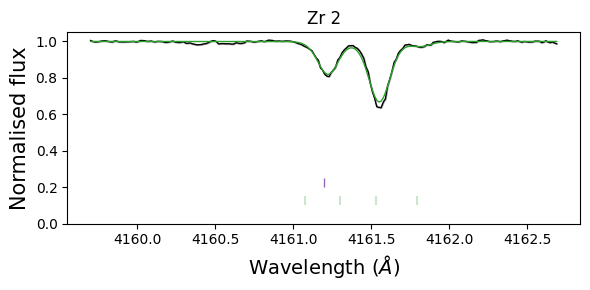

In [35]:
plt.figure(figsize=(6,3), dpi=100)

plt.plot(sme.wave.data, sme.spec.data, color='k', lw=1)
plt.plot(sme.wave.data, sme.synth.data, color='C2', lw=1)
plt.fill_between(sme.wave.data, y1=sme.spec.data-sme.uncs.data, y2=sme.spec.data+sme.uncs.data, color='grey', alpha=0.5, zorder=0)

elems_to_include = ['Zr 2']
for wline, species in pd.DataFrame(sme.linelist)[['wlcent', 'species']].values:
    if 'H 1' in species:
        continue
    if (species == 'Fe 1') | (species == 'Fe 2'):
        plt.vlines(wline, 0.1, 0.15, color='r')
        # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)
    if species not in elems_to_include:
        plt.vlines(wline, 0.1, 0.15, color='g', alpha=0.2)
        # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)
        continue
    
    plt.vlines(wline, 0.20, 0.25, color='C4', lw=1)
    # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)

# plt.hlines(sme.cscale - 2*np.mean(sme.uncs.data), np.min(sme.wave.data), np.max(sme.wave.data), color='r')
# plt.vlines(5259.75+0.05, 1.0, 0.0, color='b')
# plt.vlines(5259.75-0.05, 1.0, 0.0, color='b')

plt.title('%s' %elems_to_include[0])
plt.ylim(0.0, 1.05)
plt.xlabel(r'Wavelength ($\AA$)', size=14)
plt.ylabel('Normalised flux', size=15)

plt.tight_layout()
plt.show()

In [122]:
sme.fitresults.values

array([-3.65957815])

In [93]:
1./(sme.fitresults.gradient[0])

0.006517509848606026

In [149]:
#Merging of files per element

In [38]:
# elem_to_merge = 'zn' # ['mg', 'ca', 'si', 'sc', 'ti', 'cr', 'mn', 'co', 'ni', 'zn', 'al']

In [107]:
# os.system('cat tmp_cayrel/cayrel_elem_lines_%s_* > tmp_merged/cayrel_elem_lines_%s.csv' %(elem_to_merge,elem_to_merge))
# columns = pd.read_csv('tmp_cayrel/cayrel_elem_lines_%s_01_HD2796.csv' %elem_to_merge).columns
# lines_mn = pd.read_csv('tmp_merged/cayrel_elem_lines_%s.csv' %elem_to_merge, names=columns, comment='s')

In [177]:
lines_mn.spec_id.unique()

array(['01_HD2796', '02_HD122563', '03_HD186478', '04_BD17_3248',
       '05_BD18_5550', '06_Eric38_245', '07_BS16467_62', '08_BS16477_3',
       '09_BS17569_49', '10_CS22169_35', '11_CS22172_2', '12_CS22186_25',
       '13_CS22189_09', '14_CS22873_55', '15_CS22873_166',
       '16_CS22878_101', '17_CS22885_96', '18_CS22891_209',
       '19_CS22892_52', '20_CS22896_154', '21_CS22897_8', '22_CS22948_66',
       '23_CS22949_37', '24_CS22952_15', '25_CS22953_3', '26_CS22956_50',
       '27_CS22966_57', '28_CS22968_14', '29_CS29491_53', '30_CS29495_41',
       '31_CS29502_42', '32_CS29516_24', '33_CS29518_51', '34_CS30325_94',
       '35_CS31082_01'], dtype=object)

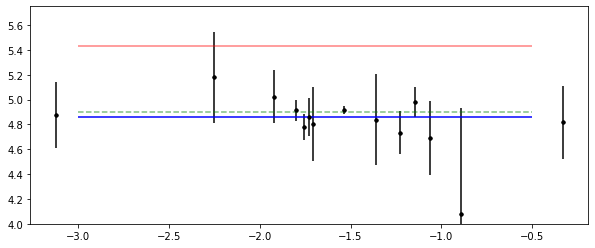

In [212]:
spec_id = '33_CS29518_51'
plt.figure(figsize=(10,4))
plt.scatter(lines_mn.query('spec_id == "%s" and emn_sme < 1.0' %spec_id).excit.values, lines_mn.query('spec_id == "%s" and emn_sme < 1.0' %spec_id).mn.values, color='k', s=10)
plt.errorbar(lines_mn.query('spec_id == "%s" and emn_sme < 1.0' %spec_id).excit.values, lines_mn.query('spec_id == "%s" and emn_sme < 1.0' %spec_id).mn.values, fmt='.k', 
            yerr=lines_mn.query('spec_id == "%s" and emn_sme < 1.0' %spec_id).emn_sme.values)
plt.hlines(np.average(lines_mn.query('spec_id == "%s" and emn_sme < 1.0' %spec_id).mn.values, 
                      weights=1./lines_mn.query('spec_id == "%s" and emn_sme < 1.0' %spec_id).emn_sme.values**2.), -3, -0.5, color='g', ls='--', alpha=0.5)
plt.hlines(solar.abund.get_element('Mn'), -3, -0.5, color='r', alpha=0.5)
plt.hlines(cayrel_mn.query('spec_id == "%s"' %spec_id).loge.values - cayrel_mn.query('spec_id == "%s"' %spec_id).monh.values, -3, -0.5, color='b')

plt.ylim(4.0, 5.75)
plt.show()

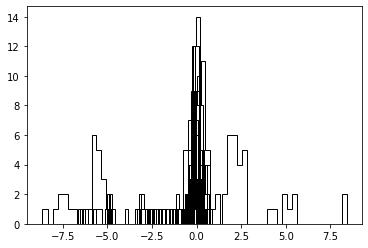

In [132]:
for line in np.unique(lines_mg.wl_line.values):
    try:
        plt.hist(lines_mn.query('wl_line == %4.2f' %line).mn.values - lines_mn.query('wl_line == %4.2f' %line).mn.values[1], bins=30, histtype='step', color='k', stacked=True)
    except:
        continue
# plt.xlim(-4, 2)
plt.show()

In [41]:
#Plots for checking

In [63]:
# sme = SME_Structure.load('sme_save/Cayrel_01_HD2796.sme')
# sme = SME_Structure.load('sme_save/Cayrel_03_HD186478.sme')
# sme = SME_Structure.load('sme_save/cayrel_elem_ba_35_CS31082_01.sme')
sme = SME_Structure.load('sme_save/cayrel_elem_pr_lines_35_CS31082_01_5259.71.sme')

[2025-04-22 11:23:42,210] [INFO] [sme:load:839]: Loading SME file sme_save/cayrel_elem_pr_lines_35_CS31082_01_5259.71.sme


INFO - Loading SME file sme_save/cayrel_elem_pr_lines_35_CS31082_01_5259.71.sme


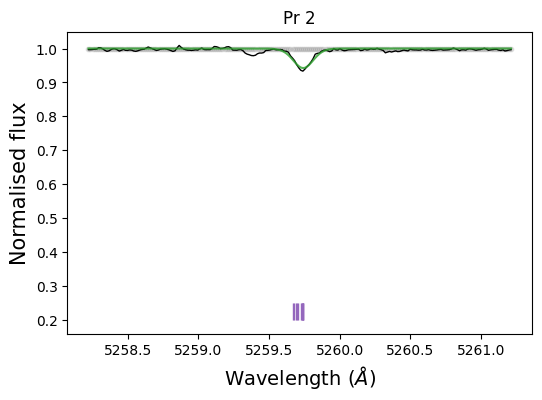

In [65]:
plt.figure(figsize=(6,4), dpi=100)

plt.plot(sme.wave.data, sme.spec.data, color='k', lw=1)
# plt.errorbar(sme.wave.data, sme.spec.data, fmt='k.', yerr=0.1*sme.uncs.data, lw=1, ms=1)
plt.plot(sme.wave.data, sme.synth.data, color='C2', lw=1.5, alpha=0.8)

plt.scatter(sme.wave.data, sme.mask.data, s=10, color='grey', alpha=0.2)

elems_to_include = ['Pr 2']
for wline, species in pd.DataFrame(sme.linelist)[['wlcent', 'species']].values:
    if 'H 1' in species:
        continue
    if (species == 'Fe 1') | (species == 'Fe 2'):
        plt.vlines(wline, 0.1, 0.15, color='r')
    if species not in elems_to_include:
        plt.vlines(wline, 0.1, 0.15, color='g', alpha=0.2)
        # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)
        continue
    
    plt.vlines(wline, 0.20, 0.25, color='C4', lw=1)
    # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)
plt.title('%s' %elems_to_include[0])
# plt.xlim(4000, 4020)
# plt.xlim(4128, 4131.5) #Eu
# plt.xlim(4129.5, 4130) #Eu
# plt.xlim(4203, 4207) #Eu
# plt.xlim(3815, 3825)

# plt.xlim(4125, 4135) #Ba
# plt.xlim(4164, 4168) #Ba
# plt.xlim(4285, 4290) #Ba
# plt.xlim(4552, 4556) #Ba
# plt.xlim(4932, 4936) #Ba

# plt.xlim(4213, 4219) #Sr
# plt.xlim(4075, 4080) #Sr

# plt.xlim(3937, 3952) #Al
# plt.ylim(0.0, 1.1)

plt.xlabel(r'Wavelength ($\AA$)', size=14)
plt.ylabel('Normalised flux', size=15)
plt.show()

In [66]:
sme.fitresults.values

array([2.11338585])

In [67]:
sme.fitresults.values+sme.monh, sme.vrad

(array([-0.49087535]), array([0.54010985]))

In [68]:
sme.fitresults.fit_uncertainties, sme.fitresults.uncertainties

([0.016596916149868905], array([0.09969072]))

In [69]:
sme.fitresults.values

array([2.11338585])

In [70]:
elem = 'pr'
lines = pd.read_csv('tmp_cayrel/cayrel_elem_lines_%s_35_CS31082_01.csv' %elem)
lines['log%s' %elem.upper()] = lines['%s' %elem].values + cayrel.query('spec_id == "35_CS31082_01"').monh.values

In [71]:
lines = lines.query('e%s_sme < 0.5 and e%s_sme > 0.0 and %s < 10.0' %(elem, elem, elem))

In [72]:
lines

,spec_id,species,wl_line,excit,gflog,pr,epr_sme,epr_fit,n_iter_pr,logPR
0,35_CS31082_01,Pr 2,4061.78,0.6333,-1.690,2.082,0.073,0.073,12,-0.522261
1,35_CS31082_01,Pr 2,4062.30,0.4219,-2.963,2.070,0.058,0.079,12,-0.534261
2,35_CS31082_01,Pr 2,5219.48,0.7953,-2.189,2.061,0.122,0.013,18,-0.543261
3,35_CS31082_01,Pr 2,5259.71,0.6334,-1.962,2.113,0.100,0.017,20,-0.491261


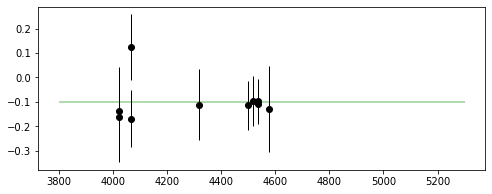

In [150]:
plt.figure(figsize=(8,3))

plt.scatter(lines.wl_line.values, lines['log%s' %elem.upper()].values, color='k')
plt.errorbar(lines.wl_line.values, lines['log%s' %elem.upper()].values, fmt='k.', yerr=lines['e%s_sme' %elem].values, lw=1)
plt.hlines(np.average(lines['log%s' %elem.upper()].values, weights=1./lines['e%s_sme' %elem].values**2.), 3800, 5300, color='C2', alpha=0.5, zorder=0)
plt.show()

In [151]:
lines.wl_line.values

array([4022.05, 4022.97, 4066.73, 4068.32, 4318.93, 4499.48, 4519.63,
       4537.23, 4538.25, 4578.64])

In [152]:
np.average(lines['log%s' %elem.upper()].values, weights=1./lines['e%s_sme' %elem].values**2.)

-0.09857645176076027